# Setup

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# import copy
import pathlib
import warnings

from datetime import datetime
import json
import numpy as np
import pandas as pd

from prophet import Prophet #, serialize
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import plotly.graph_objs as go

import mlflow
from mlflow.models import infer_signature
import optuna

from pprint import pformat

In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import prophet_helper, general_helper

In [3]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
saved_model_dir = root_dir / "models"
secret_dir = root_dir / "secrets"

In [4]:
raw_data = pd.read_csv(processed_data_dir / "klhk_usable_linearimputed_coord.csv")

# Data Processing

In [5]:
col_remap = {
    'klhk_usable_linearimputed_csv_stasiun':'stasiun',
    'klhk_usable_linearimputed_csv_lin_pm25':'pm25',
    'klhk_usable_linearimputed_csv_read_time':'read_time',
    'XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Latitude':'longitude',
    'XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Longitude':'latitude'
    }

# rename columns and use only important columns
processed_data = raw_data[col_remap.keys()].rename(columns=col_remap).drop(columns=['longitude','latitude'])

# drop some data from a stasiun
to_drop = np.arange(9201,processed_data[processed_data['stasiun'] == 'Depok Pancoran Mas'].index.max()+1)
processed_data = processed_data.drop(to_drop)

# convert to datetime
processed_data['read_time'] = pd.to_datetime(processed_data['read_time'], format="%d/%m/%Y %H:%M:%S")

In [6]:
# Group by 'stasiun' and calculate min and max 'read_time'
result = processed_data.groupby('stasiun').agg({'read_time': ['min', 'max']}).reset_index()

# Rename the columns for clarity
result.columns = ['stasiun', 'min_read_time', 'max_read_time']

In [7]:
result

,stasiun,min_read_time,max_read_time
0,Bekasi Kayuringin,2023-06-01,2023-09-04 23:00:00
1,Bekasi Sukamahi,2023-06-01,2023-09-04 23:00:00
2,Bogor Tanah Sereal,2023-06-01,2023-09-04 23:00:00
3,Depok Pancoran Mas,2023-06-01,2023-09-04 08:00:00
4,Karawang Wetan,2023-06-01,2023-09-04 23:00:00
5,Tangerang Pasir Jaya,2023-06-01,2023-09-04 23:00:00


In [8]:
# Define the proportions for train, validation, and test sets
train_frac = 0.8  # 60% of the data for training
test_frac = 0.2   # 20% for testing

# X_train, X_test, y_train, y_test = train_test_split(
#     processed_data,
#     processed_data_y,
#     test_size=test_frac,
#     # stratify=processed_data['stasiun'],
#     random_state=RANDOM_STATE, shuffle=False)

stasiun_counts = processed_data['stasiun'].value_counts()

# Initialize empty DataFrames for training and testing sets.
train_df_list = []
test_df_list = []

# Iterate through unique 'stasiun' values and split data proportionally.
for stasiun, count in stasiun_counts.items():
    stasiun_data_train = processed_data[processed_data['stasiun'] == stasiun]
    train_df, test_df = train_test_split(stasiun_data_train, test_size=int(count * test_frac), random_state=42, shuffle=False)

    # Append the split data to the respective DataFrames.
    train_df_list.append(train_df)
    test_df_list.append(test_df)
    # train_df = train_df.concat(train_data).sort_index()
    # test_df = test_df.concat(test_data).sort_index()

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

In [9]:
with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    display(train_df)

,stasiun,pm25,read_time
0,Bekasi Kayuringin,96.0,2023-06-01 00:00:00
...,...,...,...
8743,Depok Pancoran Mas,51.0,2023-08-16 07:00:00


# Training pipeline

In [ ]:
used_stasiun = 'Bekasi Kayuringin'
kayuringin_data_train = prophet_helper.isolate_stasiun(train_df, used_stasiun)
kayuringin_data_test = prophet_helper.isolate_stasiun(test_df, used_stasiun)

In [9]:
# setup baseline model
prophet_baseline = Prophet()
prophet_baseline.add_country_holidays(country_name='ID')

In [10]:
# train baseline model
prophet_baseline.fit(kayuringin_data_train)

14:51:28 - cmdstanpy - INFO - Chain [1] start processing
14:51:28 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# inferencing using baseline model
kayuringin_forecast = prophet_baseline.predict(kayuringin_data_test.drop(columns=['y']))
with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    display(kayuringin_forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,Buddha's Birthday,Buddha's Birthday_lower,Buddha's Birthday_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Silence,Day of Silence_lower,Day of Silence_upper,Eid al-Adha,Eid al-Adha_lower,Eid al-Adha_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,Eid al-Fitr Second Day,Eid al-Fitr Second Day_lower,Eid al-Fitr Second Day_upper,Good Friday,Good Friday_lower,Good Friday_upper,Independence Day,Independence Day_lower,Independence Day_upper,International Labor Day,International Labor Day_lower,International Labor Day_upper,Islamic New Year,Islamic New Year_lower,Islamic New Year_upper,Lunar New Year,Lunar New Year_lower,Lunar New Year_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Pancasila Day,Pancasila Day_lower,Pancasila Day_upper,The Prophet's Ascension,The Prophet's Ascension_lower,The Prophet's Ascension_upper,The Prophet's Birthday* (*estimated),The Prophet's Birthday* (*estimated)_lower,The Prophet's Birthday* (*estimated)_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-08-16 20:00:00,88.833989,77.113575,108.905199,88.833989,88.833989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.589912,3.589912,3.589912,-0.079580,-0.079580,-0.079580,0.0,0.0,0.0,3.669491,3.669491,3.669491,0.0,0.0,0.0,92.423901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2023-09-04 23:00:00,84.057963,63.704918,95.514737,82.347473,85.830337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.531533,-4.531533,-4.531533,-0.084019,-0.084019,-0.084019,0.0,0.0,0.0,-4.447515,-4.447515,-4.447515,0.0,0.0,0.0,79.526430


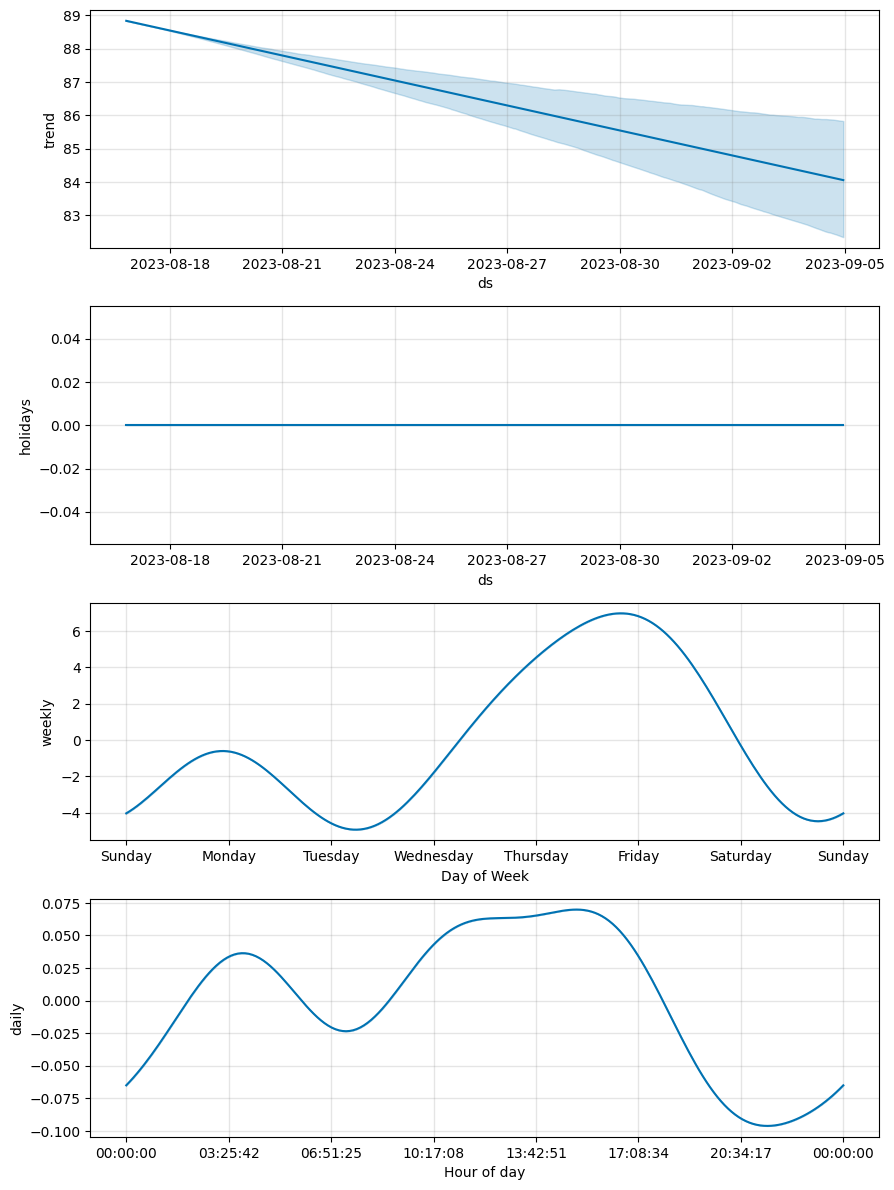

In [12]:
fig = prophet_baseline.plot_components(kayuringin_forecast)

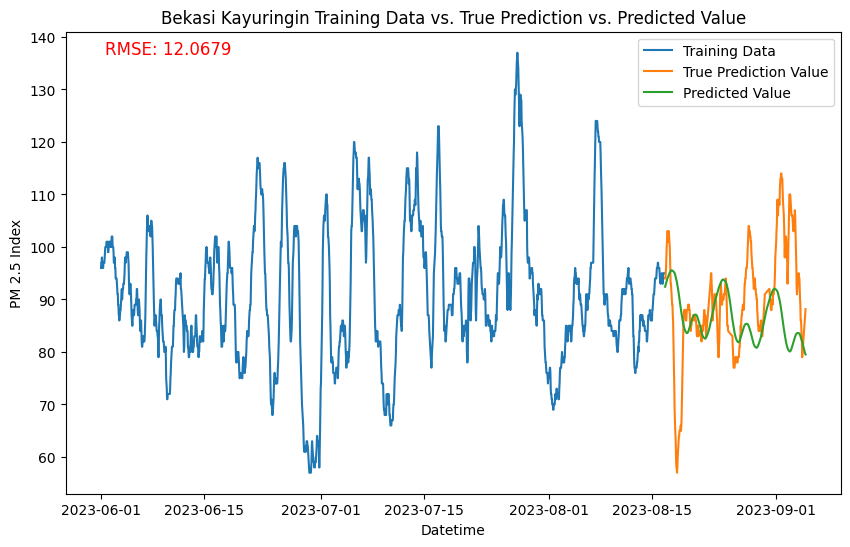

In [13]:
fig, rmse = prophet_helper.plot_test(
    stasiun_name=used_stasiun,
    train_df=kayuringin_data_train,
    forecast_df=kayuringin_forecast,
    test_df=kayuringin_data_test
)
fig.show()

# Cross Validation

In [14]:
horizon=24*3
df_cv = cross_validation(
    prophet_baseline,
    # initial=f'{horizon*3} hours',
    # period=f'{12} hours',
    horizon=f'{horizon} hours',
    parallel="processes"
    )
df_p = performance_metrics(df_cv)

In [15]:
metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
# cv_metrics = performance_metrics(metrics_raw)
metrics = {k: df_p[k].mean() for k in metric_keys}

In [16]:
# Sort the DataFrame by RMSE in ascending order
sorted_df = df_p.sort_values(by='rmse', ascending=True)

# Get the row with the lowest RMSE value (i.e., the best horizon)
best_horizon_row = sorted_df.iloc[0]

# Extract the best horizon from the row
best_horizon = best_horizon_row['horizon']
best_horizon

Timedelta('0 days 08:00:00')

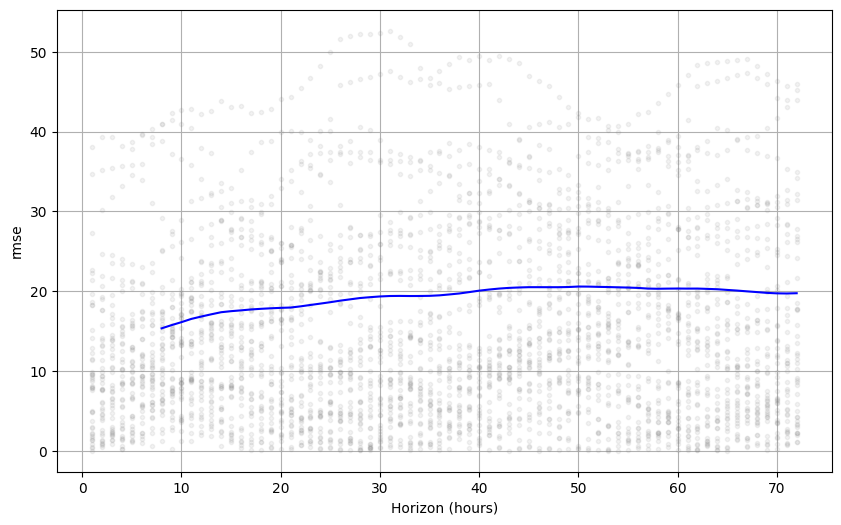

In [17]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Experimentation
- Each station should have one mlflow run or optuna study name
- Use optuna to search the hyperparameters (create custom function). To test:
    - changepoint_prior_scale - range of [0.001, 0.5]
    - seasonality_prior_scale - range of [0.01, 20]
    - holidays_prior_scale - range of [0.01, 10]
    - seasonality_mode - ['additive', 'multiplicative']
    - forecasting horizon - [12, 24*7], multiplication of 12 - affecting the cv too?
    - add holiday - [true, false]
- Connect to MLflow. To log:
    - figure
        - plot_cross_validation_metric (from cross_validation)
        - inference plot (train+validation and test)

In [10]:
# Obtain hyperparameters for this trial
def suggest_hyperparameters(trial):
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 20)
    holidays_prior_scale = trial.suggest_float("holidays_prior_scale", 0.01, 10)
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ['additive', 'multiplicative'])
    forecast_horizon = trial.suggest_int("forecast_horizon", 14,24*7,12)
    add_holiday = trial.suggest_categorical("add_holiday", [True, False])

    # print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return (
        changepoint_prior_scale,
        seasonality_prior_scale,
        holidays_prior_scale,
        seasonality_mode,
        forecast_horizon,
        add_holiday
    )

In [57]:
# turn this into objective function
def objective(trial):
    with mlflow.start_run(experiment_id=experiment_id):
        # params definition
        (
            changepoint_prior_scale,
            seasonality_prior_scale,
            holidays_prior_scale,
            seasonality_mode,
            forecast_horizon,
            add_holiday
        ) = suggest_hyperparameters(trial)
        params = {
            "changepoint_prior_scale": changepoint_prior_scale,
            "seasonality_prior_scale": seasonality_prior_scale,
            "holidays_prior_scale": holidays_prior_scale,
            "seasonality_mode": seasonality_mode,
            "forecast_horizon": forecast_horizon,
            "add_holiday": add_holiday
        }
        mlflow.log_params(params)

        # model preparation
        prophet_model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            seasonality_mode=seasonality_mode
        )
        if add_holiday:
            prophet_model.add_country_holidays(country_name='ID')
        else:
            pass
        prophet_model.fit(data_train)

        # cross validation
        metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
        metrics_raw = cross_validation(
            model=prophet_model,
            horizon=f'{forecast_horizon} hours',
            parallel="processes",
            disable_tqdm=True,
        )
        cv_metrics = performance_metrics(metrics_raw)
        
        sorted_df = cv_metrics.sort_values(by='rmse', ascending=True)
        best_horizon_row = sorted_df.iloc[0]
        best_horizon = best_horizon_row['horizon']
        # mlflow.log_param("best_horizon",str(best_horizon))

        metrics = {f'cv_{k}': cv_metrics[k].mean() for k in metric_keys}
        mlflow.log_metrics(metrics)

        # prediction
        predictions = prophet_model.predict(data_test.drop(columns=['y']))

        # log model
        MODEL_ARTIFACT_PATH = "model"
        train = prophet_model.history
        signature = infer_signature(train, predictions)
        model_detail = '_'.join(str(value)[:5] for value in params.values())
        mlflow.prophet.log_model(
            prophet_model,
            artifact_path=MODEL_ARTIFACT_PATH,
            signature=signature,
            registered_model_name=f"prophet_{model_detail}"
            )

        # log artifact
        # cv result
        cv_result = plot_cross_validation_metric(metrics_raw, metric='rmse')
        mlflow.log_figure(cv_result, "img/cv_rmse.png")
        # prediction plot
        precidtion_plot, test_rmse = prophet_helper.plot_test(
            stasiun_name=used_stasiun,
            train_df=data_train,
            forecast_df=predictions,
            test_df=data_test
        )
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_figure(precidtion_plot, "img/test_rmse.png")
        # model_uri = mlflow.get_artifact_uri(MODEL_ARTIFACT_PATH)
        # print(f"Model artifact logged to: {model_uri}")
    mlflow.end_run()
    return metrics['cv_rmse']

In [ ]:
for used_stasiun in processed_data['stasiun'].unique():
    print(f"\n-----------Initiating study for {used_stasiun} station-----------")
    data_train = prophet_helper.isolate_stasiun(train_df, used_stasiun)
    data_test = prophet_helper.isolate_stasiun(test_df, used_stasiun)

    experiment_name = f"{used_stasiun}_prophet_test"
    
    # # use this to track in dagshub
    # experiment_id = general_helper.initiate_mlflow_dagshub(secret_dir/"mlflow_dagshub.json", experiment_name)
    
    # use this to track locally
    experiment_id = general_helper.initiate_mlflow_dagshub(experiment_name)

    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(pruner=pruner, direction="minimize")
    study.optimize(
        objective,
        n_trials=2,
        )

In [11]:
secret_json = secret_dir/"mlflow_dagshub.json"
with open(secret_json, "r") as f:
    secrets = json.load(f)

os.environ['MLFLOW_TRACKING_USERNAME'] = secrets['MLFLOW_TRACKING_USERNAME']
os.environ['MLFLOW_TRACKING_PASSWORD'] = secrets['MLFLOW_TRACKING_PASSWORD']
os.environ['MLFLOW_TRACKING_URI'] = secrets['MLFLOW_TRACKING_URI']

In [14]:
# for used_stasiun in processed_data['stasiun'].unique()[3:]:
#     experiment_name = f"{used_stasiun}_prophet_test"
#     # Check if the experiment exists, and if not, create it
#     if not mlflow.get_experiment_by_name(experiment_name):
#         mlflow.create_experiment(experiment_name)
#         mlflow.set_experiment(experiment_name)
#     experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    
#     with mlflow.start_run(experiment_id=experiment_id):
#         mlflow.log_metric("test", random().random())
        
#     mlflow.end_run()

## Testing

In [12]:
# for used_stasiun in processed_data['stasiun'].unique()[3:]:
experiment_name = "test"
# Check if the experiment exists, and if not, create it
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_metric("test", 10)

mlflow.end_run()

RestException: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}

In [16]:
# def objective(trial):
#     # Start a new mlflow run
#     with mlflow.start_run(experiment_id=experiment_id):
#         # Get hyperparameter suggestions created by optuna and log them as params using mlflow
#         # params definition
#         changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,forecast_horizon,add_holiday = suggest_hyperparameters(trial)
#         mlflow.log_params(trial.params)

#     # Return the best validation loss achieved by the network.
#     # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
#     return changepoint_prior_scale

In [17]:
# # Create the optuna study which shares the experiment name
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=3)

In [18]:
# from optuna.integration.mlflow import MLflowCallback

# def objective(trial):
#     x = trial.suggest_float("x", -10, 10)
#     with mlflow.start_run():
#         mlflow.log_metric("test", (x - 1) ** 2)
#     mlflow.end_run()
#     return (x - 2) ** 2


# mlflc = MLflowCallback(
#     tracking_uri=secrets['MLFLOW_TRACKING_URI'],
# )

# study = optuna.create_study(study_name="my_study")
# study.optimize(objective, n_trials=2, callbacks=[mlflc])

In [36]:
# mlflow.end_run()

# Inferencing

In [81]:
client = mlflow.tracking.MlflowClient(tracking_uri=secrets["MLFLOW_TRACKING_URI"])
searched_experiment_name = 'x'
searched_exp_id = mlflow.get_experiment_by_name(searched_experiment_name).experiment_id
runs = client.search_runs(searched_exp_id, "", order_by=["metrics.test_rmse DESC"], max_results=1)
best_run = runs[0]

In [90]:
clean_model_name = '_'.join(map(str, best_run.data.params.values()))
clean_model_name = "prophet_"+clean_model_name
clean_model_name

'prophet_0.26762061816561206_3.1646927903446853_7.4595853023566505_multiplicative_50_True'

In [91]:
model_uri = f"models:/{clean_model_name}/latest"
loaded_model = mlflow.prophet.load_model(model_uri)

In [ ]:
predictions = loaded_model.predict(data_test.drop(columns=['y']))

# Hotstart

In [21]:
# # https://facebook.github.io/prophet/docs/additional_topics.html#updating-fitted-models
# m2 = Prophet().fit(df, init=prophet_helper.warm_start_params(m1))  # Adding the last day, warm-starting from m1